In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

Testing out the examples from the celerite documentation: https://celerite.readthedocs.io/en/stable/tutorials/first/

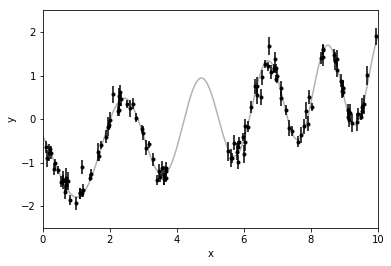

In [6]:
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

In [7]:
# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [8]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -6.756596382629269


In [9]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:terms[0]:log_S0', -0.8497786656258695), ('kernel:terms[0]:log_omega0', 1.0986122886681098), ('kernel:terms[1]:log_S0', -1.1963522559058422), ('kernel:terms[1]:log_Q', 0.0), ('kernel:terms[1]:log_omega0', 1.0986122886681098)])

parameter_names:
('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')

parameter_vector:
[-0.84977867  1.09861229 -1.19635226  0.          1.09861229]

parameter_bounds:
[(-15, 15), (-15, 15), (-15, 15), (-15, 15), (-15, 15)]



In [11]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -16.56320171269553
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.84217094e-06,  1.05160325e-04, -4.54747351e-05, -5.68434189e-06,
       -5.20117283e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 252
      nit: 30
   status: 0
  success: True
        x: array([ 3.277941  , -2.02450473, -4.16135883,  2.34185049,  1.13554439])


In [12]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', 3.277941000956591),
             ('kernel:terms[0]:log_omega0', -2.024504730787932),
             ('kernel:terms[1]:log_S0', -4.161358828835926),
             ('kernel:terms[1]:log_Q', 2.3418504900107107),
             ('kernel:terms[1]:log_omega0', 1.1355443876655091)])

In [13]:
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

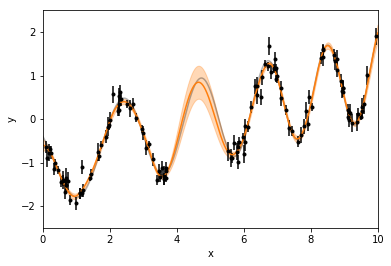

In [14]:
color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

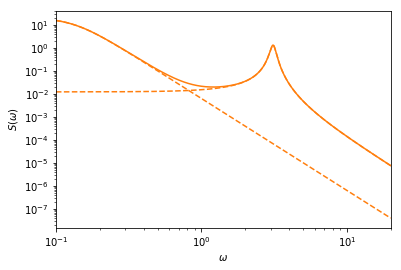

In [15]:
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");